In [1]:
import iris
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import datetime
import numpy as np
import iris.coords as icoords
import iris.coord_categorisation
import iris.quickplot as qplt 
import numpy.ma as ma
from iris.util import broadcast_to_shape

In [2]:
#setting file path and ensemble codes
#ensembles grouped by QBO phase
dir_in_coupled = '/shared/netscratch/lrm49/Laura/'
coupled_jul_east = ['u-bv020','u-bw758','u-bw761','u-bw762','u-bw764','u-bw765'] 
coupled_jul_west = ['u-bw763','u-bw766','u-bw767'] 
coupled_jan_east = ['u-ca322', 'u-ca323', 'u-ca324', 'u-ca325', 'u-ca328']
coupled_jan_west = ['u-ca326', 'u-ca327', 'u-ca330','u-ca331']

In [3]:
#defining a function to calculate global average T
def area_average(cube):
    
    if cube.coord('latitude').bounds is None:
        cube.coord('latitude').guess_bounds()
        cube.coord('longitude').guess_bounds()
    
    grid_areas = iris.analysis.cartography.area_weights(cube)
    average = cube.collapsed(['latitude','longitude'],iris.analysis.MEAN, weights=grid_areas)
    
    return average

In [4]:
#defining function to merge cube list into single large cube
def merge_cubes(cubes): 
    
    """
    Merge all ensemble members into one cube
    All cubes given the same time coordinate
    """

    big_cube = iris.cube.CubeList()
    n=1
    for cube in cubes:
        ensemble_coord = icoords.AuxCoord(n, standard_name='realization')
        new_cube = cube.copy()
        new_cube.add_aux_coord(ensemble_coord)
        big_cube.append(new_cube)
        n+=1
    
    return big_cube.merge_cube()

In [5]:
#defining function to reset cube times
def time_reset(cubes): 
    
    time_coord = cubes[0].coord('time')
    n=1
    for cube in cubes:
        cube.remove_coord('time')
        cube.add_dim_coord(time_coord,0)
        cube.remove_coord('forecast_reference_time')
        cube.remove_coord('forecast_period')
        n+=1
    
    return 

In [6]:
### Easterly ###

saod_east = iris.cube.CubeList()
for job_id in coupled_jul_east:

    SAOD_cubes = iris.load(dir_in_coupled+'Samalas_July/'+job_id+'_optical_vars.nc')
    total_SAOD = SAOD_cubes[0] + SAOD_cubes[2] + SAOD_cubes[3] + SAOD_cubes[4] #loading in all aerosol modes
    total_SAOD_550 = total_SAOD.extract(iris.Constraint(pseudo_level = 3))[6:120] #550nm level

    saod_east.append(total_SAOD_550)
    
for job_id in coupled_jan_east:
    
    SAOD_cubes = iris.load(dir_in_coupled+'Samalas_Jan/'+job_id+'_optical_vars.nc')
    total_SAOD = SAOD_cubes[0] + SAOD_cubes[2] + SAOD_cubes[3] + SAOD_cubes[4] #loading in all aerosol modes
    total_SAOD_550 = total_SAOD.extract(iris.Constraint(pseudo_level = 3))[0:114] #550nm level

    saod_east.append(total_SAOD_550)
    
  

In [7]:
### Westerly ###

saod_west = iris.cube.CubeList()
for job_id in coupled_jul_west:

    SAOD_cubes = iris.load(dir_in_coupled+'Samalas_July/'+job_id+'_optical_vars.nc')
    total_SAOD = SAOD_cubes[0] + SAOD_cubes[2] + SAOD_cubes[3] + SAOD_cubes[4] #loading in all aerosol modes
    total_SAOD_550 = total_SAOD.extract(iris.Constraint(pseudo_level = 3))[6:120] #550nm level

    saod_west.append(total_SAOD_550)
    
for job_id in coupled_jan_west:
    
    SAOD_cubes = iris.load(dir_in_coupled+'Samalas_Jan/'+job_id+'_optical_vars.nc')
    total_SAOD = SAOD_cubes[0] + SAOD_cubes[2] + SAOD_cubes[3] + SAOD_cubes[4] #loading in all aerosol modes
    total_SAOD_550 = total_SAOD.extract(iris.Constraint(pseudo_level = 3))[0:114] #550nm level

    saod_west.append(total_SAOD_550)
    

In [8]:
#resetting time
time_reset(saod_east)
time_reset(saod_west)

In [9]:
#merging list of cubes into single large cube
one_big_east = merge_cubes(saod_east)
one_big_west = merge_cubes(saod_west)

In [10]:
NH_constraint = iris.Constraint(latitude=lambda v: 0 <= v <= 90) #Northern Hemisphere
SH_constraint = iris.Constraint(latitude=lambda v: -90 <= v <= 0) #Southern Hemisphere

east_ratio = iris.cube.CubeList()

## Calculating SAOD ratio

for i in range(0,11):
    nh_saod = saod_east[i].extract(NH_constraint)
    sh_saod = saod_east[i].extract(SH_constraint)
    nh_avg = area_average(nh_saod)
    sh_avg = area_average(sh_saod)
    ratio = (nh_avg - sh_avg)/ (nh_avg+sh_avg)
               
    east_ratio.append(ratio)

In [11]:
NH_constraint = iris.Constraint(latitude=lambda v: 0 <= v <= 90) #Northern Hemisphere
SH_constraint = iris.Constraint(latitude=lambda v: -90 <= v <= 0) #Southern Hemisphere

west_ratio = iris.cube.CubeList()

## Calculating SAOD ratio

for i in range(0,7):
    nh_saod = saod_west[i].extract(NH_constraint)
    sh_saod = saod_west[i].extract(SH_constraint)
    nh_avg = area_average(nh_saod)
    sh_avg = area_average(sh_saod)
    ratio = (nh_avg - sh_avg )/ (nh_avg+sh_avg)
               
    west_ratio.append(ratio)

In [12]:
#merging ratio cubes
big_east_ratios = merge_cubes(east_ratio)
big_west_ratios = merge_cubes(west_ratio)

In [13]:
#calcualting means for E/W
mean_east = big_east_ratios.collapsed('realization',iris.analysis.MEAN)
mean_west = big_west_ratios.collapsed('realization',iris.analysis.MEAN)

/home/lw602/.conda/envs/py27iris/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'realization'.
  warnings.warn(msg.format(self.name()))


In [14]:
#defining new time
time_1 = range(0,114)

In [15]:
#creating zero line
zero = []
for n in range(0,114):
    n = 0
    zero.append(n)

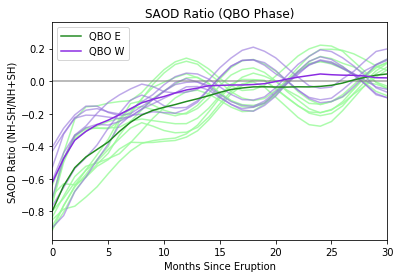

In [16]:
for cube in big_east_ratios.slices_over('realization'): # loop through ensemble members
    plt.plot(time_1,cube.data,color='palegreen', alpha = 0.8)

for cube in big_west_ratios.slices_over('realization'): # loop through ensemble members
    plt.plot(time_1,cube.data,color='mediumpurple', alpha = 0.6)

plt.plot(time_1,zero,color='grey', alpha = 0.7)#zero line

plt.plot(time_1,mean_east.data,color='forestgreen')#easterly mean
plt.plot(time_1, mean_west.data,color='blueviolet')#westerly mean
    
plt.xlim(time_1[0],time_1[30]) # plot only 5 years


from matplotlib.lines import Line2D
plt.title('SAOD Ratio (QBO Phase)')
plt.xlabel('Months Since Eruption')
plt.ylabel('SAOD Ratio (NH-SH/NH+SH)')
july_line = Line2D([0], [0], label='QBO E', color='forestgreen')
jan_line = Line2D([0], [0], label='QBO W', color='blueviolet')
plt.legend(handles=[july_line, jan_line])

plt.savefig('SAOD_Ratio_QBO.pdf')
